# WordNet: Comparison Class Inference Free Production Pilot

In [20]:
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from string import punctuation
from collections import Counter
import pandas as pd
import json
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from helpers import *

In [3]:
trial_data = "../data/pilot-classElicitation-free-3/class-elicitation-free-3-trials.csv"
data = pd.read_csv(trial_data) 



In [5]:
# exclude workers failing memory check

memory_check_file = '../data/pilot-classElicitation-free-3/class-elicitation-free-3-catch_trials.csv'
memory_check_df = pd.read_csv(memory_check_file)[['workerid', 'correct']]

passed_memory_check = memory_check_df.groupby(['workerid']).sum() >= 8

data = pd.merge(data, passed_memory_check, on = ['workerid'], how = 'left')
data = data[data['correct'] == True].drop(columns = ['correct'])



In [6]:
# insert stimulus id
    
data['stim_id'] = data.apply(lambda row: get_stim_dimension(row['np'], row['context'], row['np_positiveness']), 
                                                    axis = 1)

In [7]:
# get superordinates and degree from stimulus list
stimuli_info = "../experiments/js/noun_elicitation_pilot.json"
with open(stimuli_info) as stim_info:
    stimuli = json.load(stim_info)["examples"]
#     print(stimuli)
data['superordinate'] = data['stim_id'].apply(lambda x: stimuli[x].get('superordinate') )
data['degree'] = data['stim_id'].apply(lambda x: stimuli[x].get('degree'))
data

,workerid,rt,trial_type,trial_num,adj_positiveness,np_positiveness,context,np,adj,response,stim_id,superordinate,degree
0,0,12247,free_class_elicitation,1,positive,positive,Veronica is walking outside and hears the cry ...,rooster,loud,sounds,13,birds,sound
1,0,6518,free_class_elicitation,2,positive,neither-nor,The waitress brings Kim her food at the diner....,fruit,warm,food,18,foods,temperature
2,0,6050,free_class_elicitation,3,positive,positive,Stephen is sitting in a gymnasium.,gymnasium,loud,locations,7,places in schools,sound
3,0,5734,free_class_elicitation,4,negative,positive,Sophie sees a giraffe at the zoo.,giraffe,short,giraffes,15,animals,height
4,0,7155,free_class_elicitation,5,positive,negative,Michael is looking for a place to live and che...,apartment,large,apartments,10,houses,size
5,0,10107,free_class_elicitation,6,positive,positive,Stephanie takes a first sip from a cup of coffee.,coffee,hot,drinks,8,drinks,temperature
6,0,8113,free_class_elicitation,7,negative,negative,Michelle lifts up a baby named Allen.,baby,light,things,12,human,weight
7,0,3953,free_class_elicitation,8,negative,neither-nor,Jennifer is helping a friend move and picks up...,box,light,boxes,9,things you carry when moving,weight
8,0,7438,free_class_elicitation,9,negative,positive,Gary hears somebody playing the drums.,drums,quiet,musical instruments,3,instruments,sound
9,0,4781,free_class_elicitation,10,positive,negative,Kathleen looks at the price of a box of wine.,box of wine,expensive,wines,6,alcoholic drinks,price


## WordNet preprocessing

In [8]:
lemmatizer = WordNetLemmatizer()
tokenizer = WhitespaceTokenizer()

# responses handling
# split off punctuation
data['clean_resp'] = data['response'].apply(lambda s: s.strip(punctuation))

# remove quotechars
data['clean_resp'] = data['clean_resp'].apply(lambda s: s.replace('&quotechar', ''))

# split multi-word responses and cast to lower case
data['clean_resp'] = data['clean_resp'].apply(lambda s: tokenizer.tokenize(s.lower()))

# lemmatize
data['lemma'] = data['clean_resp'].apply(lambda word: [lemmatizer.lemmatize(x) for x in word])

# most common lemmata
# Counter(data['lemma']).most_common()
# data['lemma']

# join them back into a string separated by one underscore to get some multi-word synsets 
data['clean_lemma'] = data['lemma'].apply(lambda s:'_'.join(s))
# data['clean_lemma']


# noun phrases handling 
data['np_lemma'] = data['np'].apply(lambda s: [lemmatizer.lemmatize(x) for x in tokenizer.tokenize(s)])
data['np_lemma'] = data['np_lemma'].apply(lambda s:'_'.join(s))

# lemmatize superordinates and degree scales
data['superordinate'] = data['superordinate'].apply(lambda word: [lemmatizer.lemmatize(x) for x in tokenizer.tokenize(word)]) 
data['superordinate'] = data['superordinate'].apply(lambda s:' '.join(s))
data['degree'] = data['degree'].apply(lambda word: lemmatizer.lemmatize(word))

In [9]:
# WordNet: extract useful information

#get whole synset
# data['lemma_synsets'] = data['lemma'].apply(lambda x: wn.synsets(str(x[0])) if len(x) == 1 else 0)

 # get only first entry in synset corresponding to word itself 
 # both following functions catch exception if there is no synset 
data['resp_lemma_synsets'] = data['clean_lemma'].apply(lambda x: wn.synsets(str(x))[0] if len(wn.synsets(str(x))) > 0 else np.nan)
# data.dropna()

# create np synsets, get the first one corresponding to NP
data['np_lemma_synsets'] = data['np_lemma'].apply(lambda x: wn.synsets(str(x))[0] if len(wn.synsets(str(x))) > 0 else np.nan)
# data

# get hypernyms of all words in synsets, corresponding to responses 
# data['hypernyms'] = data['lemma_synsets'].apply(lambda x: [syn.hypernyms() for syn in x])

# # get hypernym for one synset corresponding to response
subset = data.dropna()
# subset
subset['one_hypernym_resp'] = subset['resp_lemma_synsets'].apply(lambda x: x.hypernyms() )
# subset['one_hypernym']

# get one hypernym for np synset 
subset['one_hypernym_np'] = subset['np_lemma_synsets'].apply(lambda x: x.hypernyms())

hypernym = lambda x: x.hypernyms()
# get closure of hypernyms for responses
subset['all_hypernyms_resp'] = subset['resp_lemma_synsets'].apply(lambda s: list(s.closure(hypernym)) )

# get closure of hypernyms for nps
subset['all_hypernyms_np'] = subset['np_lemma_synsets'].apply(lambda s: list(s.closure(hypernym)))
subset
# data['all_hypernyms']

/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

,workerid,rt,trial_type,trial_num,adj_positiveness,np_positiveness,context,np,adj,response,...,clean_resp,lemma,clean_lemma,np_lemma,resp_lemma_synsets,np_lemma_synsets,one_hypernym_resp,one_hypernym_np,all_hypernyms_resp,all_hypernyms_np
0,0,12247,free_class_elicitation,1,positive,positive,Veronica is walking outside and hears the cry ...,rooster,loud,sounds,...,[sounds],[sound],sound,rooster,Synset('sound.n.01'),Synset('cock.n.04'),[Synset('sound_property.n.01')],[Synset('chicken.n.02')],"[Synset('sound_property.n.01'), Synset('proper...","[Synset('chicken.n.02'), Synset('domestic_fowl..."
1,0,6518,free_class_elicitation,2,positive,neither-nor,The waitress brings Kim her food at the diner....,fruit,warm,food,...,[food],[food],food,fruit,Synset('food.n.01'),Synset('fruit.n.01'),[Synset('substance.n.07')],[Synset('reproductive_structure.n.01')],"[Synset('substance.n.07'), Synset('matter.n.03...","[Synset('reproductive_structure.n.01'), Synset..."
2,0,6050,free_class_elicitation,3,positive,positive,Stephen is sitting in a gymnasium.,gymnasium,loud,locations,...,[locations],[location],location,gymnasium,Synset('location.n.01'),Synset('secondary_school.n.01'),[Synset('object.n.01')],[Synset('school.n.01')],"[Synset('object.n.01'), Synset('physical_entit...","[Synset('school.n.01'), Synset('educational_in..."
3,0,5734,free_class_elicitation,4,negative,positive,Sophie sees a giraffe at the zoo.,giraffe,short,giraffes,...,[giraffes],[giraffe],giraffe,giraffe,Synset('giraffe.n.01'),Synset('giraffe.n.01'),[Synset('ruminant.n.01')],[Synset('ruminant.n.01')],"[Synset('ruminant.n.01'), Synset('even-toed_un...","[Synset('ruminant.n.01'), Synset('even-toed_un..."
4,0,7155,free_class_elicitation,5,positive,negative,Michael is looking for a place to live and che...,apartment,large,apartments,...,[apartments],[apartment],apartment,apartment,Synset('apartment.n.01'),Synset('apartment.n.01'),[Synset('housing.n.01')],[Synset('housing.n.01')],"[Synset('housing.n.01'), Synset('structure.n.0...","[Synset('housing.n.01'), Synset('structure.n.0..."
5,0,10107,free_class_elicitation,6,positive,positive,Stephanie takes a first sip from a cup of coffee.,coffee,hot,drinks,...,[drinks],[drink],drink,coffee,Synset('drink.n.01'),Synset('coffee.n.01'),[Synset('helping.n.01')],[Synset('beverage.n.01')],"[Synset('helping.n.01'), Synset('small_indefin...","[Synset('beverage.n.01'), Synset('food.n.01'),..."
6,0,8113,free_class_elicitation,7,negative,negative,Michelle lifts up a baby named Allen.,baby,light,things,...,[things],[thing],thing,baby,Synset('thing.n.01'),Synset('baby.n.01'),[Synset('situation.n.01')],[Synset('child.n.02')],"[Synset('situation.n.01'), Synset('state.n.02'...","[Synset('child.n.02'), Synset('offspring.n.01'..."
7,0,3953,free_class_elicitation,8,negative,neither-nor,Jennifer is helping a friend move and picks up...,box,light,boxes,...,[boxes],[box],box,box,Synset('box.n.01'),Synset('box.n.01'),[Synset('container.n.01')],[Synset('container.n.01')],"[Synset('container.n.01'), Synset('instrumenta...","[Synset('container.n.01'), Synset('instrumenta..."
8,0,7438,free_class_elicitation,9,negative,positive,Gary hears somebody playing the drums.,drums,quiet,musical instruments,...,"[musical, instruments]","[musical, instrument]",musical_instrument,drum,Synset('musical_instrument.n.01'),Synset('drum.n.01'),[Synset('device.n.01')],[Synset('percussion_instrument.n.01')],"[Synset('device.n.01'), Synset('instrumentalit...","[Synset('percussion_instrument.n.01'), Synset(..."
10,0,4002,free_class_elicitation,11,positive,neither-nor,Mika is at the butchershop and looks at the pr...,chicken,expensive,meats,...,[meats],[meat],meat,chicken,Synset('meat.n.01'),Synset('chicken.n.01'),[Synset('food.n.02')],[Synset('poultry.n.02')],"[Synset('food.n.02'), Synset('solid.n.01'), Sy...","[Synset('poultry.n.02'), Synset('bird.n.02'), ..."


## Inherited hypernyms of NPs

In [19]:
# looking at entries which do not have synsets
data[data['np_lemma_synsets'].isna()].drop_duplicates(['np_lemma'])
# following transformations into words having synsets 
# townhouse - cottage
# box of wine -> wine [caution]
# bottle of wine -> wine_bottle
# the morning - morning
# bottle of top shelf liquor -> scotch ??
# the evening -> evening
# piece of clothing -> clothing 
def replace_np(string, np, new):
    return string.replace(np, new)

nps = ['townhouse', 'box_of_wine', 'bottle_of_wine', 'the_morning', 'bottle_of_top-shelf_liquor', 'the_evening', 'piece_of_clothing']
new = ['cottage', 'wine', 'wine_bottle', 'morning', 'scotch', 'evening', 'clothing']

for np, x in list(zip(nps, new)):
   data['np_lemma'] = data['np_lemma'].apply(lambda s: replace_np(s, np, x))
    
# rerun the synset and hypernyms computation 
data['np_lemma_synsets'] = data['np_lemma'].apply(lambda x: wn.synsets(str(x))[0] if len(wn.synsets(str(x))) > 0 else np.nan)
data['np_hyper'] = data['np_lemma_synsets'].apply(lambda x: x.hypernyms())

# ----------------------------------------
# WORDS FOR WHICH EMBEDDINGS NEED TO BE COMPUTED 
# -----------------------------------------
# choose the unique nps 
unique_nps = data.drop_duplicates('np_lemma_synsets')

unique_nps['np_inherit_hyper'] = unique_nps['np_lemma_synsets'].apply(lambda s: list(s.closure(hypernym)))

# get the words of the inherited hypernyms
unique_nps['hypers_list'] = unique_nps['np_inherit_hyper'].apply(lambda s: [x.name().split('.')[0] for x in s])
unique_nps['hypers_list'] = unique_nps['hypers_list'].apply(lambda s: [x.replace('_', ' ') for x in s])
list_hyper = unique_nps['hypers_list'].tolist()


# append superordinates and degree words 
list_hyper.append(data['superordinate'].drop_duplicates().tolist())
list_hyper.append(data['degree'].drop_duplicates().tolist())
list_unique_hypers = []
for i in list_hyper:
    for x in i:
        list_unique_hypers.append(x)

list_unique_hypers = list(set(list_unique_hypers))
print(list_unique_hypers)


['synthetic resin', 'musical instrument', 'foam', 'clock time', 'feline', 'structure', 'styrene', 'housing', 'reading', 'rider', 'carnivore', 'diapsid', 'contestant', 'agent', 'primate', 'animal', 'social group', 'shape', 'nutriment', 'domestic animal', 'physical entity', 'matter', 'consumer goods', 'furnishing', 'entertainment', 'device', 'alloy', 'container', 'covering', 'chicken', 'chemical', 'season', 'rodent', 'seabird', 'binary compound', 'mail', 'beverage', 'apodiform bird', 'vertebrate', 'mixture', 'height', 'bowed stringed instrument', 'building', 'drink', 'keyboard instrument', 'time period', 'commodity', 'meat', 'collection', 'creation', 'aquatic bird', 'psychological feature', 'frozen dessert', 'concave shape', 'product', 'entity', 'whole', 'solid', 'show', 'price', 'gallinaceous bird', 'player', 'food', 'reproductive structure', 'domestic fowl', 'juvenile', 'artifact', 'abstraction', 'mammal', 'ruminant', 'weapon', 'object', 'alcohol', 'house', 'athlete', 'even-toed ungula

/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [42]:
data[['superordinate', 'degree']].drop_duplicates()
# data['degree'].drop_duplicates()

,superordinate,degree
0,bird,sound
1,food,temperature
2,place in school,sound
3,animal,height
4,house,size
5,drink,temperature
6,human,weight
7,thing you carry when moving,weight
8,instrument,sound
9,alcoholic drink,price


In [8]:
# compute path similarity between np and response synsets 

def compute_path_sim(np, resp):
    return np.path_similarity(resp)
    
def compute_wup_sim(np, resp):
    return np.wup_similarity(resp)

subset['path_sim'] = subset.apply(lambda s: compute_path_sim(s['np_lemma_synsets'], s['resp_lemma_synsets']), axis=1) 
subset['wup_sim'] = subset.apply(lambda s: compute_wup_sim(s['np_lemma_synsets'], s['resp_lemma_synsets']), axis=1)
subset['resp_hyper_wup'] = subset.apply(lambda x: compute_wup_sim(x['one_hypernym_resp'][0], x['resp_lemma_synsets']) if len(x['one_hypernym_resp']) > 0 else np.nan, axis=1)
subset[['workerid', 'clean_lemma', 'np_lemma', 'resp_lemma_synsets', 'np_lemma_synsets','one_hypernym_resp', 'one_hypernym_np','wup_sim', 'resp_hyper_wup']]


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

,workerid,clean_lemma,np_lemma,resp_lemma_synsets,np_lemma_synsets,one_hypernym_resp,one_hypernym_np,wup_sim,resp_hyper_wup
0,0,sound,rooster,Synset('sound.n.01'),Synset('cock.n.04'),[Synset('sound_property.n.01')],[Synset('chicken.n.02')],0.100000,0.909091
1,0,food,fruit,Synset('food.n.01'),Synset('fruit.n.01'),[Synset('substance.n.07')],[Synset('reproductive_structure.n.01')],0.285714,0.888889
2,0,location,gymnasium,Synset('location.n.01'),Synset('secondary_school.n.01'),[Synset('object.n.01')],[Synset('school.n.01')],0.153846,0.857143
3,0,giraffe,giraffe,Synset('giraffe.n.01'),Synset('giraffe.n.01'),[Synset('ruminant.n.01')],[Synset('ruminant.n.01')],1.000000,0.965517
4,0,apartment,apartment,Synset('apartment.n.01'),Synset('apartment.n.01'),[Synset('housing.n.01')],[Synset('housing.n.01')],1.000000,0.933333
5,0,drink,coffee,Synset('drink.n.01'),Synset('coffee.n.01'),[Synset('helping.n.01')],[Synset('beverage.n.01')],0.250000,0.923077
6,0,thing,baby,Synset('thing.n.01'),Synset('baby.n.01'),[Synset('situation.n.01')],[Synset('child.n.02')],0.142857,0.909091
7,0,box,box,Synset('box.n.01'),Synset('box.n.01'),[Synset('container.n.01')],[Synset('container.n.01')],1.000000,0.933333
8,0,musical_instrument,drum,Synset('musical_instrument.n.01'),Synset('drum.n.01'),[Synset('device.n.01')],[Synset('percussion_instrument.n.01')],0.888889,0.933333
10,0,meat,chicken,Synset('meat.n.01'),Synset('chicken.n.01'),[Synset('food.n.02')],[Synset('poultry.n.02')],0.800000,0.909091


C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


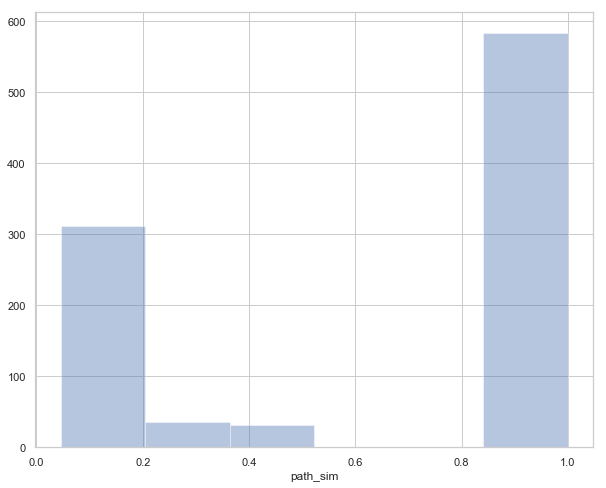

In [9]:
# draw a plot of distributions of path similarities
sb.set(style="whitegrid")
subset = subset.dropna()
plot, ax1 = plt.subplots(1,1)
plot.set_size_inches(10,8)
ax = sb.distplot(subset['path_sim'], ax = ax1, kde=False)


C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


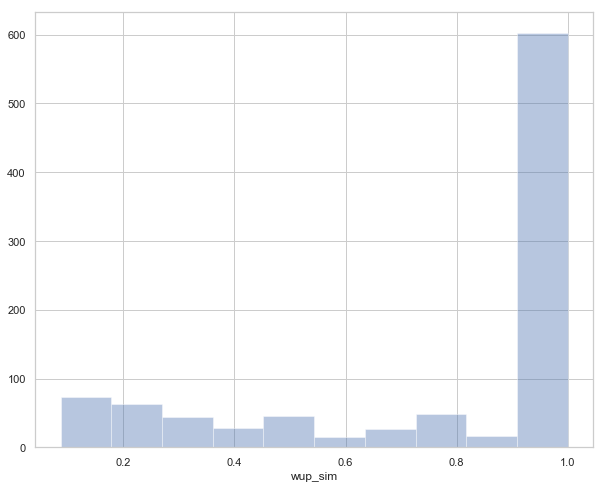

In [10]:
sb.set(style="whitegrid")
subset = subset.dropna()
plot, ax1 = plt.subplots(1,1)
plot.set_size_inches(10,8)
ax = sb.distplot(subset['wup_sim'], ax = ax1, kde=False)


C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


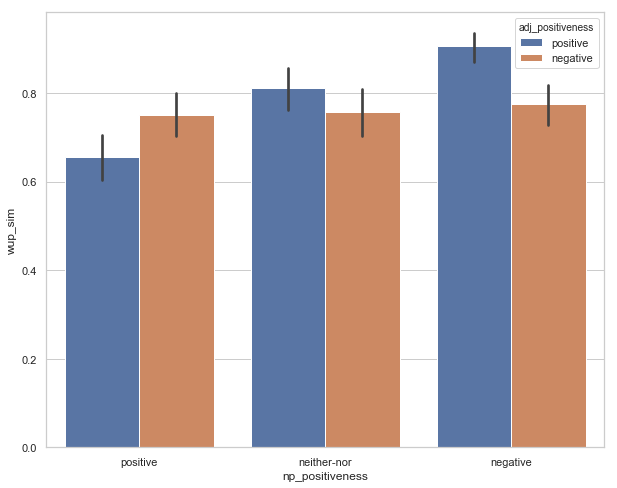

In [11]:
sb.set(style="whitegrid")
# subset = subset.dropna()
plot, ax1 = plt.subplots(1,1)
plot.set_size_inches(10,8)
ax = sb.barplot(x="np_positiveness",y="wup_sim", hue="adj_positiveness", data=subset, ax = ax1)


C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


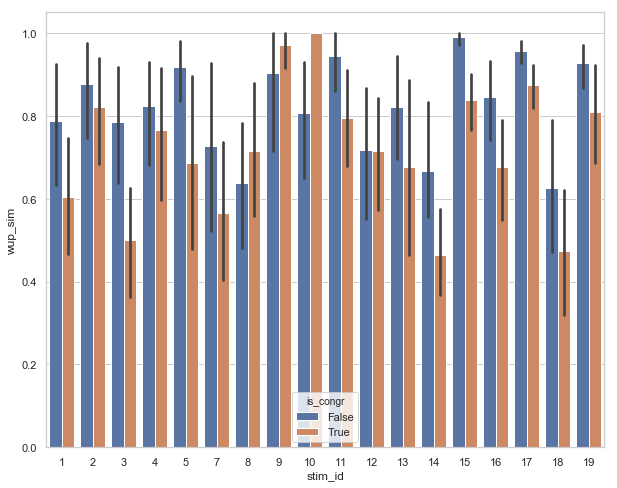

In [12]:
# group by congruency and item
subset_with_congr = subset[ subset['np_positiveness'] != 'neither-nor']
subset_with_congr['is_congr'] = subset_with_congr.apply(lambda s: True if s['np_positiveness'] == s['adj_positiveness'] else False, axis=1)
# subset_with_congr

sb.set(style="whitegrid")
# subset = subset.dropna()
plot, ax1 = plt.subplots(1,1)
plot.set_size_inches(10,8)
ax = sb.barplot(x="stim_id",y="wup_sim", hue = "is_congr", data=subset_with_congr, ax = ax1)


In [13]:
# dealing with multi-wotd nps and responses 
# there are synsets for some multiword expressions joined by _
multi_data = data

#lemmatize superordinate for further processing 
multi_data['superordinate'] = multi_data['superordinate'].apply(lambda s: [lemmatizer.lemmatize(x) for x in tokenizer.tokenize(s)])
# try new synset and hypernym retrieval

multi_data
# # get hypernyms of all words in synsets, corresponding to responses 
# # data['hypernyms'] = data['lemma_synsets'].apply(lambda x: [syn.hypernyms() for syn in x])

# # # get hypernym for one synset corresponding to response
# multi_subset = multi_data.dropna()
# # subset
# multi_subset['one_hypernym_resp'] = multi_subset['resp_lemma_synsets'].apply(lambda x: x.hypernyms() )
# # subset['one_hypernym']

# # get one hypernym for np synset 
# multi_subset['one_hypernym_np'] = multi_subset['np_lemma_synsets'].apply(lambda x: x.hypernyms())

# hypernym = lambda x: x.hypernyms()
# # get closure of hypernyms for responses
# multi_subset['all_hypernyms_resp'] = multi_subset['resp_lemma_synsets'].apply(lambda s: list(s.closure(hypernym)) )

# # get closure of hypernyms for nps
# multi_subset['all_hypernyms_np'] = multi_subset['np_lemma_synsets'].apply(lambda s: list(s.closure(hypernym)))
# multi_subset

,workerid,rt,trial_type,trial_num,adj_positiveness,np_positiveness,context,np,adj,response,stim_id,superordinate,degree,clean_resp,lemma,clean_lemma,np_lemma,resp_lemma_synsets,np_lemma_synsets
0,0,12247,free_class_elicitation,1,positive,positive,Veronica is walking outside and hears the cry ...,rooster,loud,sounds,13,[bird],sound,[sounds],[sound],sound,rooster,Synset('sound.n.01'),Synset('cock.n.04')
1,0,6518,free_class_elicitation,2,positive,neither-nor,The waitress brings Kim her food at the diner....,fruit,warm,food,18,[food],temperature,[food],[food],food,fruit,Synset('food.n.01'),Synset('fruit.n.01')
2,0,6050,free_class_elicitation,3,positive,positive,Stephen is sitting in a gymnasium.,gymnasium,loud,locations,7,"[place, in, school]",sound,[locations],[location],location,gymnasium,Synset('location.n.01'),Synset('secondary_school.n.01')
3,0,5734,free_class_elicitation,4,negative,positive,Sophie sees a giraffe at the zoo.,giraffe,short,giraffes,15,[animal],height,[giraffes],[giraffe],giraffe,giraffe,Synset('giraffe.n.01'),Synset('giraffe.n.01')
4,0,7155,free_class_elicitation,5,positive,negative,Michael is looking for a place to live and che...,apartment,large,apartments,10,[house],size,[apartments],[apartment],apartment,apartment,Synset('apartment.n.01'),Synset('apartment.n.01')
5,0,10107,free_class_elicitation,6,positive,positive,Stephanie takes a first sip from a cup of coffee.,coffee,hot,drinks,8,[drink],temperature,[drinks],[drink],drink,coffee,Synset('drink.n.01'),Synset('coffee.n.01')
6,0,8113,free_class_elicitation,7,negative,negative,Michelle lifts up a baby named Allen.,baby,light,things,12,[human],weight,[things],[thing],thing,baby,Synset('thing.n.01'),Synset('baby.n.01')
7,0,3953,free_class_elicitation,8,negative,neither-nor,Jennifer is helping a friend move and picks up...,box,light,boxes,9,"[thing, you, carry, when, moving]",weight,[boxes],[box],box,box,Synset('box.n.01'),Synset('box.n.01')
8,0,7438,free_class_elicitation,9,negative,positive,Gary hears somebody playing the drums.,drums,quiet,musical instruments,3,[instrument],sound,"[musical, instruments]","[musical, instrument]",musical_instrument,drum,Synset('musical_instrument.n.01'),Synset('drum.n.01')
9,0,4781,free_class_elicitation,10,positive,negative,Kathleen looks at the price of a box of wine.,box of wine,expensive,wines,6,"[alcoholic, drink]",price,[wines],[wine],wine,box_of_wine,Synset('wine.n.01'),NaN


In [14]:
wn.synsets("liquor_bottle")

[]